In [3]:
import pandas as pd
import glob
import os

files = glob.glob("../data/*.csv")   # or stock_data/*.csv — use your folder name

combined = []

for file in files:
    df = pd.read_csv(file)

    # extract only the ticker (just the filename)
    ticker = os.path.basename(file).replace(".csv", "")
    df["ticker"] = ticker  # now it's AAPL, GOOG, etc.

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"])
    combined.append(df)

merged_df = pd.concat(combined, ignore_index=True)
merged_df = merged_df.sort_values(["Date", "ticker"])

merged_df.to_csv("cleaned_stocks.csv", index=False)

merged_df.head()

,Date,Close,High,Low,Open,Volume,ticker
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200,AAPL
3774,2009-01-02,2.718000,2.726500,2.553500,2.567500,145928000,AMZN
7548,2009-01-02,7.948608,7.960977,7.557264,7.633949,144961322,GOOG
14245,2009-01-02,14.872976,14.924187,14.170662,14.287715,50084000,MSFT
18019,2009-01-02,0.199652,0.201027,0.184294,0.184982,497124000,NVDA


## SMA (Simple Moving Average)

In [4]:
# Calculate 20-day and 50-day SMA
merged_df["SMA_20"] = merged_df.groupby("ticker")["Close"].transform(lambda x: x.rolling(window=20).mean())
merged_df["SMA_50"] = merged_df.groupby("ticker")["Close"].transform(lambda x: x.rolling(window=50).mean())

# Preview
merged_df[["Date","ticker","Close","SMA_20","SMA_50"]].head(10)


,Date,ticker,Close,SMA_20,SMA_50
0,2009-01-02,AAPL,2.721686,NaN,NaN
3774,2009-01-02,AMZN,2.718000,NaN,NaN
7548,2009-01-02,GOOG,7.948608,NaN,NaN
14245,2009-01-02,MSFT,14.872976,NaN,NaN
18019,2009-01-02,NVDA,0.199652,NaN,NaN
1,2009-01-05,AAPL,2.836553,NaN,NaN
3775,2009-01-05,AMZN,2.703000,NaN,NaN
7549,2009-01-05,GOOG,8.115089,NaN,NaN
14246,2009-01-05,MSFT,15.011971,NaN,NaN
18020,2009-01-05,NVDA,0.203319,NaN,NaN


## Relative Strength Index

In [ ]:
def compute_rsi(series, period=14):
    delta = series.diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Exponential Moving Average (EMA)
merged_df['EMA_20'] = merged_df.groupby('ticker')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())


In [6]:
merged_df[["Date","ticker","Close","RSI_14"]].head(20)

,Date,ticker,Close,RSI_14
0,2009-01-02,AAPL,2.721686,NaN
3774,2009-01-02,AMZN,2.718000,NaN
7548,2009-01-02,GOOG,7.948608,NaN
14245,2009-01-02,MSFT,14.872976,NaN
18019,2009-01-02,NVDA,0.199652,NaN
1,2009-01-05,AAPL,2.836553,NaN
3775,2009-01-05,AMZN,2.703000,NaN
7549,2009-01-05,GOOG,8.115089,NaN
14246,2009-01-05,MSFT,15.011971,NaN
18020,2009-01-05,NVDA,0.203319,NaN


## Add SMA and EMA

In [15]:
# Apply RSI per ticker
merged_df["RSI_14"] = merged_df.groupby("ticker")["Close"].transform(lambda x: compute_rsi(x))

# Simple Moving Average (SMA)
merged_df['SMA_20'] = merged_df.groupby('ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())


## Add MACD Manually

In [17]:
# MACD Calculation
merged_df['EMA_12'] = merged_df.groupby('ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
merged_df['EMA_26'] = merged_df.groupby('ticker')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

merged_df['MACD'] = merged_df['EMA_12'] - merged_df['EMA_26']
merged_df['Signal'] = merged_df.groupby('ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())


## Visualize

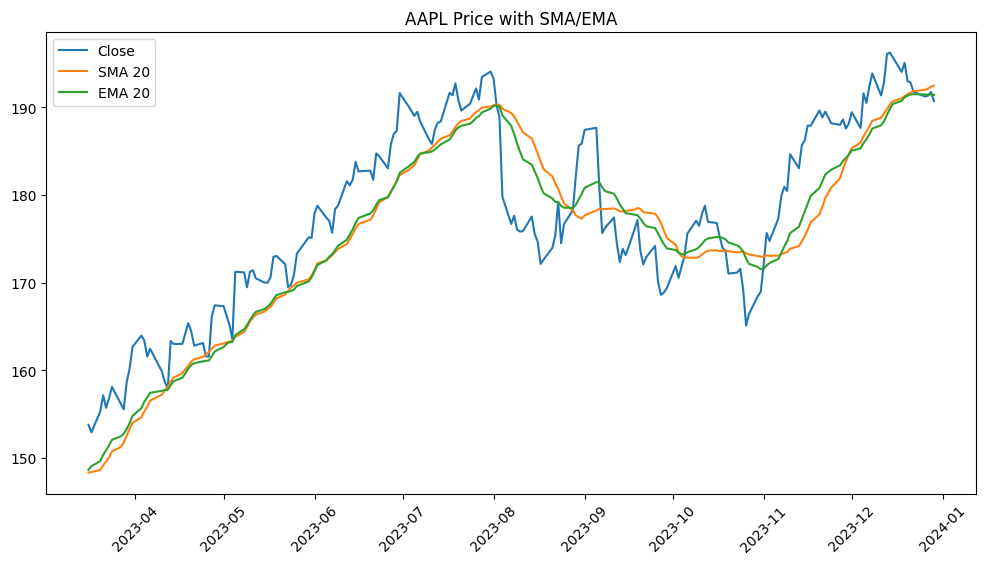

In [18]:
import matplotlib.pyplot as plt

sample = merged_df[merged_df['ticker'] == 'AAPL'].tail(200)

plt.figure(figsize=(12,6))
plt.plot(sample['Date'], sample['Close'], label='Close')
plt.plot(sample['Date'], sample['SMA_20'], label='SMA 20')
plt.plot(sample['Date'], sample['EMA_20'], label='EMA 20')
plt.legend()
plt.title('AAPL Price with SMA/EMA')
plt.xticks(rotation=45)
plt.show()


## 2. MACD Chart

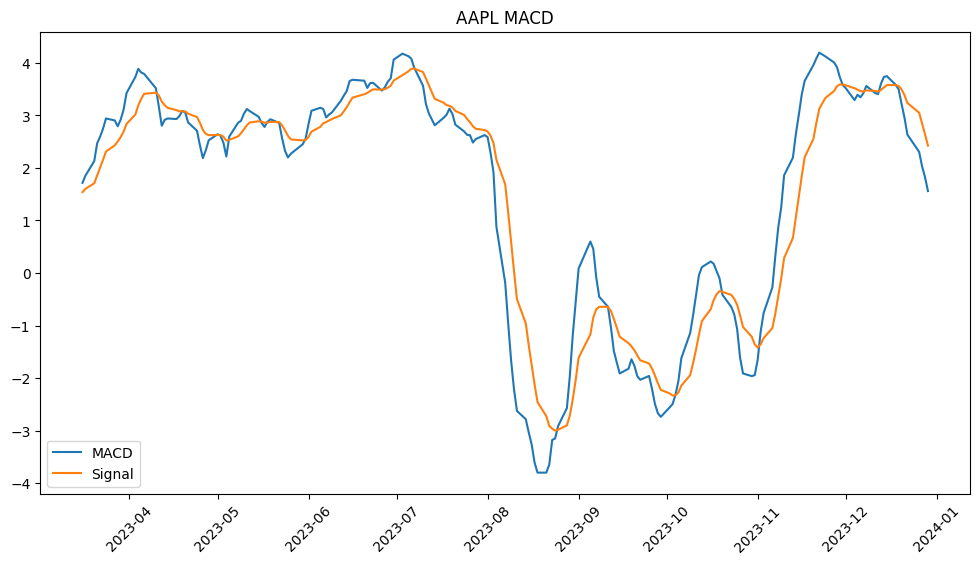

In [19]:
plt.figure(figsize=(12,6))
plt.plot(sample['Date'], sample['MACD'], label='MACD')
plt.plot(sample['Date'], sample['Signal'], label='Signal')
plt.legend()
plt.title('AAPL MACD')
plt.xticks(rotation=45)
plt.show()


## Visualize  Price with SMA/EMA

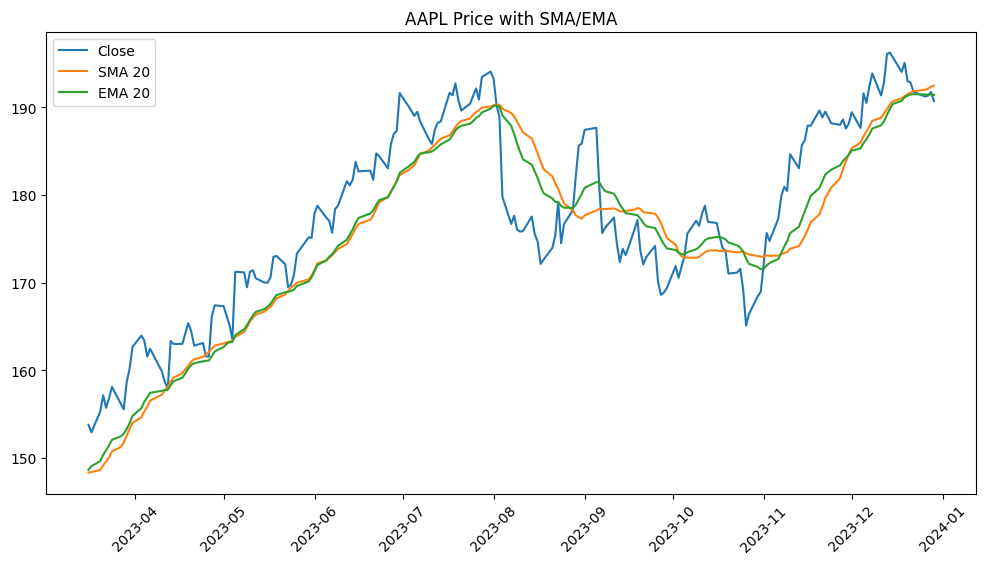

In [21]:
import matplotlib.pyplot as plt

sample = merged_df[merged_df['ticker'] == 'AAPL'].tail(200)

plt.figure(figsize=(12,6))
plt.plot(sample['Date'], sample['Close'], label='Close')
plt.plot(sample['Date'], sample['SMA_20'], label='SMA 20')
plt.plot(sample['Date'], sample['EMA_20'], label='EMA 20')
plt.legend()
plt.title('AAPL Price with SMA/EMA')
plt.xticks(rotation=45)
plt.show()


## MACD Chart

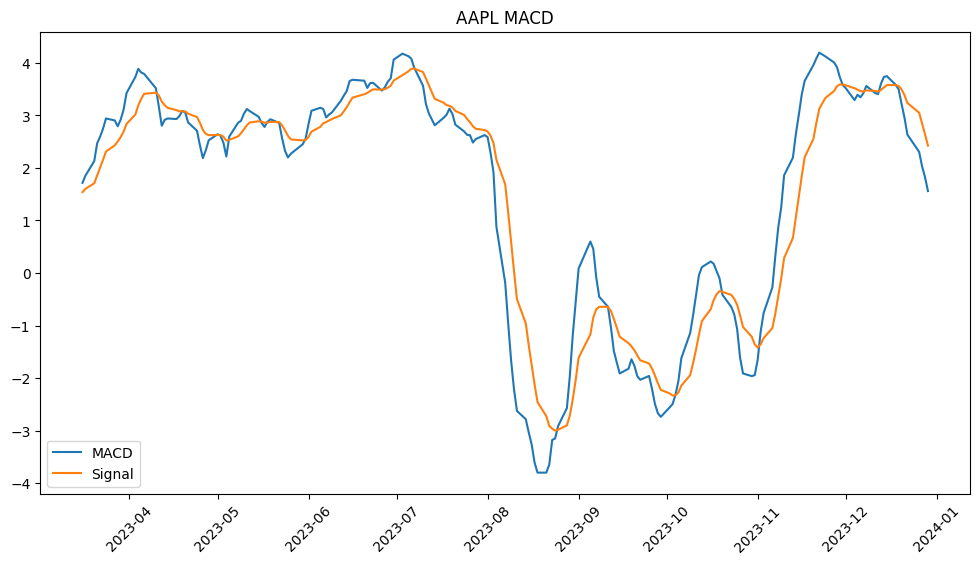

In [22]:
plt.figure(figsize=(12,6))
plt.plot(sample['Date'], sample['MACD'], label='MACD')
plt.plot(sample['Date'], sample['Signal'], label='Signal')
plt.legend()
plt.title('AAPL MACD')
plt.xticks(rotation=45)
plt.show()

In [25]:
import pandas as pd

# load news (if saved), otherwise use existing df
# df = pd.read_csv('data/financial_news.csv', parse_dates=['date'])
# load stocks
merged_df = pd.read_csv('cleaned_stocks.csv', parse_dates=['Date'])

# if you already have df in memory (from earlier cells), skip the news load line
print("News rows:", len(df))
print("Stocks rows:", len(merged_df))


News rows: 3774
Stocks rows: 21793


In [28]:
# NEWS: ensure datetime and make a date-only column
# If your news df 'date' column has timezone info it's fine; if not we try to parse it.
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # parse
# convert to UTC (safe) if timezone-aware, else assume it's already in UTC-4 per metadata; we'll normalize to date only
# if timezone-aware, convert to UTC:
try:
    if df['Date'].dt.tz is not None:
        df['date_utc'] = df['Date'].dt.tz_convert('UTC')
    else:
        df['date_utc'] = df['Date']  # naive: leave as is (we'll take the date part)
except Exception:
    df['date_utc'] = df['Date']

# news date only (trading date we will use)
df['news_date'] = df['date_utc'].dt.date

# STOCKS: Date column (already parsed), create trade_date
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
merged_df['trade_date'] = merged_df['Date'].dt.date

# Quick check
print("News date range:", df['news_date'].min(), "to", df['news_date'].max())
print("Stock date range:", merged_df['trade_date'].min(), "to", merged_df['trade_date'].max())


News date range: 2009-01-02 to 2023-12-29
Stock date range: 2009-01-02 to 2023-12-29


## Compute sentiment polarity for each headline

In [35]:
from textblob import TextBlob

news_df = pd.read_csv('../newsData/news_data.csv')
# Calculate sentiment polarity for each news headline
news_df['sentiment'] = news_df['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Quick check
news_df[['headline', 'sentiment']].head()

,headline,sentiment
0,Stocks That Hit 52-Week Highs On Friday,0.0
1,Stocks That Hit 52-Week Highs On Wednesday,0.0
2,71 Biggest Movers From Friday,0.0
3,46 Stocks Moving In Friday's Mid-Day Session,0.0
4,B of A Securities Maintains Neutral on Agilent...,0.0


In [ ]:
news_df['date'] = pd.to_datetime(news_df['date']).dt.date
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [37]:
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()
daily_sentiment.head()

,date,sentiment
0,2009-02-14 00:00:00,0.000000
1,2009-04-27 00:00:00,0.000000
2,2009-04-29 00:00:00,0.000000
3,2009-05-22 00:00:00,0.000000
4,2009-05-27 00:00:00,0.234091


In [38]:
# Sort by ticker and date first
df = df.sort_values(['ticker', 'Date'])

# Calculate daily returns
df['daily_return'] = df.groupby('ticker')['Close'].pct_change()

# Quick check
df[['Date', 'ticker', 'Close', 'daily_return']].head(10)


,Date,ticker,Close,daily_return
0,2009-01-02,NVDA,0.199652,NaN
1,2009-01-05,NVDA,0.203319,0.018370
2,2009-01-06,NVDA,0.210196,0.033822
3,2009-01-07,NVDA,0.197589,-0.059978
4,2009-01-08,NVDA,0.192546,-0.025522
5,2009-01-09,NVDA,0.181773,-0.055952
6,2009-01-12,NVDA,0.174437,-0.040353
7,2009-01-13,NVDA,0.175354,0.005256
8,2009-01-14,NVDA,0.167561,-0.044444
9,2009-01-15,NVDA,0.173521,0.035568


## Compute Daily Returns

In [39]:
# Sort by ticker and date first
df = df.sort_values(['ticker', 'Date'])

# Calculate daily returns
df['daily_return'] = df.groupby('ticker')['Close'].pct_change()

# Quick check
df[['Date', 'ticker', 'Close', 'daily_return']].head(10)


,Date,ticker,Close,daily_return
0,2009-01-02,NVDA,0.199652,NaN
1,2009-01-05,NVDA,0.203319,0.018370
2,2009-01-06,NVDA,0.210196,0.033822
3,2009-01-07,NVDA,0.197589,-0.059978
4,2009-01-08,NVDA,0.192546,-0.025522
5,2009-01-09,NVDA,0.181773,-0.055952
6,2009-01-12,NVDA,0.174437,-0.040353
7,2009-01-13,NVDA,0.175354,0.005256
8,2009-01-14,NVDA,0.167561,-0.044444
9,2009-01-15,NVDA,0.173521,0.035568


## Merge Sentiment with Stock Returns

In [ ]:
# Merge on the date column
merged_df = pd.merge(df, daily_sentiment, left_on='Date', right_on='date', how='left')

# Drop the extra 'date' column if you like
merged_df = merged_df.drop(columns=['date'])

# Check the merged result
merged_df[['Date', 'ticker', 'Close', 'daily_return', 'sentiment']].head(10)
